## Task 1 (10 Points)

Select padding sizes:

In [ ]:
import torch

N = 4
C = 3
C_out = 10
H = 8
W = 16

x = torch.ones((N, C, H, W))

# torch.Size([4, 10, 8, 16])
out1 = torch.nn.Conv2d(C, C_out, kernel_size=(3, 3), padding = 1)(x)
print(out1.shape) # for self-test

# torch.Size([4, 10, 8, 16])
out2 = torch.nn.Conv2d(C, C_out, kernel_size=(5, 5), padding = 2)(x)
print(out2.shape) # for self-test

# torch.Size([4, 10, 8, 16])
out3 = torch.nn.Conv2d(C, C_out, kernel_size=(7, 7), padding = 3)(x)
print(out3.shape) # for self-test

# torch.Size([4, 10, 8, 16])
out4 = torch.nn.Conv2d(C, C_out, kernel_size=(9, 9), padding = 4)(x)
print(out4.shape) # for self-test

# torch.Size([4, 10, 8, 16])
out5 = torch.nn.Conv2d(C, C_out, kernel_size=(3, 5), padding = (1,2))(x)
print(out5.shape) # for self-test

# torch.Size([4, 10, 22, 30])
out6 = torch.nn.Conv2d(C, C_out, kernel_size=(3, 3), padding = 8)(x)
print(out6.shape) # for self-test

# torch.Size([4, 10, 7, 15])
out7 = torch.nn.Conv2d(C, C_out, kernel_size=(4, 4), padding = 1)(x)
print(out7.shape) # for self-test

# torch.Size([4, 10, 9, 17])
out8 = torch.nn.Conv2d(C, C_out, kernel_size=(2, 2), padding = 1)(x)
print(out8.shape) # for self-test

torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 22, 30])
torch.Size([4, 10, 7, 15])
torch.Size([4, 10, 9, 17])


## Task 2 (40 Points)

Develop an architecture according to the data from the article.
To test the functionality, test your architecture on any suitable data set.

### Architectural Design Strategies
**Strategy 1.** Replace 3×3 filters with 1×1 filters
Given a budget of a certain number of convolution filters, we can choose to make the majority of these filters 1×1, since a 1×1 filter has 9× fewer parameters than a 3×3 filter.

**Strategy 2.** Decrease the number of input channels to 3×3 filters
Consider a convolution layer that is comprised entirely of 3×3 filters. The total quantity of parameters in this layer is:
(number of input channels) × (number of filters) × (3×3)
We can decrease the number of input channels to 3×3 filters using squeeze layers, mentioned in the next section.

**Strategy 3.** Downsample late in the network so that convolution layers have large activation maps
The intuition is that large activation maps (due to delayed downsampling) can lead to higher classification accuracy.

### Fire Module
![](https://miro.medium.com/v2/resize:fit:930/format:webp/1*ONk0HfLLjDcUhUjuu8iq1w.png)
A Fire module is comprised of: a squeeze convolution layer (which has only 1×1 filters), feeding into an expand layer that has a mix of 1×1 and 3×3 convolution filters.

There are three tunable dimensions (hyperparameters) in a Fire module: s1×1, e1×1, and e3×3.

s1×1: The number of 1×1 in squeeze layer.

e1×1 and e3×3: The number of 1×1 and 3×3 in expand layer.

When we use Fire modules we set s1×1 to be less than (e1×1 + e3×3), so the squeeze layer helps to limit the number of input channels to the 3×3 filters, as per Strategy 2 in previous section.
To me, it is quite a like of Inception Module.

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*y87bqk95D-IndWdHM_K9-g.png)
![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*XQGAKZb8kjoF_1lSXeIQxg.png)

## Step 0. Data preparation.

In [ ]:

import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.deterministic = True

In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

KeyboardInterrupt: ignored

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 ! kaggle datasets list

ref                                                        title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/customer-shopping-trends-dataset         Customer Shopping Trends Dataset                  146KB  2023-10-05 06:45:37           4760        116  1.0              
nelgiriyewithana/top-spotify-songs-2023                    Most Streamed Spotify Songs 2023                   47KB  2023-08-26 11:04:57          31897        961  1.0              
nelgiriyewithana/credit-card-fraud-detection-dataset-2023  Credit Card Fraud Detection Dataset 2023          143MB  2023-09-18 10:00:19           5476        185  1.0              
nelgiriyewithana/billionaires-statistics-dataset           Billionaires Statistics Dataset (202

In [ ]:
!kaggle datasets download -d jessicali9530/stanford-cars-dataset

 99% 1.81G/1.82G [00:18<00:00, 152MB/s]
100% 1.82G/1.82G [00:18<00:00, 103MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('stanford-cars-dataset.zip', 'r')
zip_ref.extractall('stanford_cars')
zip_ref.close()

In [ ]:
!cp -R /content/stanford_cars/cars_test/cars_test/* /content/stanford_cars/cars_test/
!rm -R /content/stanford_cars/cars_test/cars_test/

In [ ]:
!cp -R /content/stanford_cars/cars_train/cars_train/* /content/stanford_cars/cars_train/
!rm -R /content/stanford_cars/cars_train/cars_train/

In [ ]:
import torchvision

transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop([224,224]),
    torchvision.transforms.ToTensor()
])


cars_train =  torchvision.datasets.StanfordCars(root = './',  transform = transforms,download = False)


X_train = torch.zeros( 1000, 3, 224,224, device = device)
y_train = torch.zeros( 1000, device = device)
cnt = 0
for item in cars_train:
  X_train[cnt] = item[0]
  y_train[cnt] = item[1]
  cnt = cnt + 1
  if cnt>=1000:
    break

del cars_train

In [ ]:
import scipy.io as sio
from PIL import Image
import os
from os import listdir

test_annos = np.transpose(sio.loadmat('/content/stanford_cars/devkit/cars_test_annos_withlabels (1).mat')['annotations'])
folder_dir = "/content/stanford_cars/cars_test/"
y_test = torch.zeros(100, device = device)
X_test = torch.zeros(100,3, 224,224, device = device)
cnt = 0
for item in test_annos :
  #print(item['class'][0][0][0])
  X_test[cnt] = transforms(Image.open(folder_dir+item['fname'][0][0]))
  y_test[cnt] = item['class'][0][0][0]
  cnt = cnt + 1
  if cnt >= 100 :
    break

torch.Size([3, 224, 224])
torch.Size([224, 224, 3])


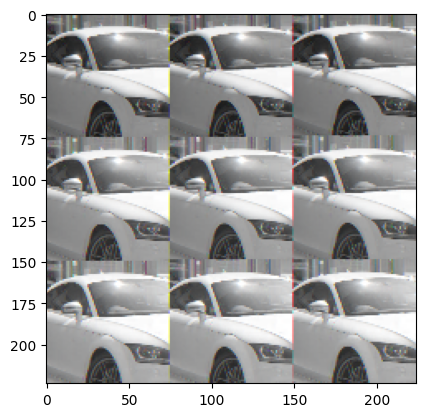

In [ ]:
tens = X_train[0, :, :].cpu()
print(tens.shape)
img = tens.view(tens.shape[2], tens.shape[1], tens.shape[0])
print(img.shape)

import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()


In [ ]:
y_train = y_train.type(torch.LongTensor)
y_test = y_test.type(torch.LongTensor)

## Step 1. Neural network architecture

In [ ]:
class FireFunc(torch.nn.Module) :
  def __init__(self, in_ch, out_ch):
    super(FireFunc,self).__init__()
    self.conv1 = torch.nn.Conv2d(kernel_size = (1,1), in_channels = in_ch, out_channels = out_ch//8)
    self.act1 = torch.nn.ReLU()
    self.conv2 = torch.nn.Conv2d(kernel_size = (1,1), in_channels = out_ch//8, out_channels = out_ch//2)
    self.conv3 = torch.nn.Conv2d(kernel_size = (3,3), in_channels = out_ch//2, out_channels = out_ch, padding = 1)
    self.act2 = torch.nn.ReLU()
  def forward(self, x) :
    x = self.conv1(x)
    x = self.act1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.act2(x)
    return x

In [ ]:
class ImageNet(torch.nn.Module):
  def __init__(self):
    super(ImageNet,self).__init__()

    self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = 96, kernel_size = (7,7), stride = 2, padding  = 3)
    self.pool1 = torch.nn.MaxPool2d(kernel_size = (3,3), stride = 2, padding = 1)
    self.fire2 = FireFunc(96,128)
    self.fire3 = FireFunc(128,128)
    self.fire4 = FireFunc(128,256)
    self.pool4 = torch.nn.MaxPool2d(kernel_size = (3,3), stride = 2)
    self.fire5 = FireFunc(256,256)
    self.fire6 = FireFunc(256,384)
    self.fire7 = FireFunc(384,384)
    self.fire8 = FireFunc(384,512)
    self.pool8 = torch.nn.MaxPool2d(kernel_size = (3,3), stride = 2)
    self.fire9 = FireFunc(512,512)
    self.conv10 = torch.nn.Conv2d(in_channels = 512, out_channels = 1000, kernel_size = (1,1), stride = 1)
    self.act1 = torch.nn.Tanh()
    self.avg10 = torch.nn.AvgPool2d(kernel_size = (13,13),stride = 1)
    self.act2 = torch.nn.Tanh()
    self.fc1 = torch.nn.Linear(1000, 196)
    self.act3 = torch.nn.Tanh()
    self.sm = torch.nn.Softmax(dim = 1)

  def forward(self,x ):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.fire2(x)
    x = self.fire3(x)
    x = self.fire4(x)
    x = self.pool4(x)
    x = self.fire5(x)
    x = self.fire6(x)
    x = self.fire7(x)
    x = self.fire8(x)
    x = self.pool8(x)
    x = self.fire9(x)
    x = self.conv10(x)
    x = self.act1(x)
    x = self.avg10(x)
    x = self.act2(x)
    x = x.view(x.size(0),x.size(1)*x.size(2)*x.size(3))
    x = self.fc1(x)
    x = self.act3(x)
    return x
  def inference(self, x):
    x = self.forward(x)
    x = self.sm(x)
    return x
imageNet = ImageNet()

## Step 2.  Loss Function

In [ ]:
loss = torch.nn.CrossEntropyLoss()

## Step 3. Optimizer

In [ ]:
optimizer = torch.optim.Adam(imageNet.parameters(), lr = 0.001)

In [ ]:
imageNet = imageNet.to(device)

## Step 4. Train Loop

In [ ]:
batch_size = 25


for epoch in range(10):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index: start_index + batch_size]
        x_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        preds = imageNet.forward(x_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()


In [ ]:
test_preds = imageNet.inference(X_test)
loss_value = loss(test_preds,y_test.type(torch.cuda.LongTensor))
test_preds = test_preds.argmax(dim = 1)
accuracy = (test_preds == y_test.type(torch.cuda.LongTensor)).float().mean()

